In [1]:
%pip install lion-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hassanmo2001","key":"8516843d5005f85e3b6959c97c0e75ed"}'}

In [4]:
%pip install -q kaggle

In [5]:
%mkdir -p ~/.kaggle

In [6]:
%cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets list -s 'noamsegal/affectnet-training-data' 

ref                                                         title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
viktormodroczky/facial-affect-dataset-relabeled-unbalanced  Facial Affect Dataset Relabeled Imbalanced  307MB  2023-04-06 09:07:01             30          1  1.0              
noamsegal/affectnet-training-data                           Facial Expressions Training Data            314MB  2023-01-16 19:40:50            739          8  1.0              
viktormodroczky/facial-affect-dataset-unbalanced            Facial Affect Dataset Imbalanced            314MB  2023-04-05 17:26:33             10          0  1.0              
viktormodroczky/facial-affect-data-relabeled                Facial Affect Dataset Relabeled Balanced      2GB  2023-04-0

In [8]:
! kaggle datasets download noamsegal/affectnet-training-data

 99% 312M/314M [00:09<00:00, 41.2MB/s]
100% 314M/314M [00:09<00:00, 34.9MB/s]


In [9]:
! unzip '/content/affectnet-training-data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: sad/image0025659.jpg    
  inflating: sad/image0025666.jpg    
  inflating: sad/image0025673.jpg    
  inflating: sad/image0025679.jpg    
  inflating: sad/image0025681.jpg    
  inflating: sad/image0025693.jpg    
  inflating: sad/image0025694.jpg    
  inflating: sad/image0025697.jpg    
  inflating: sad/image0025715.jpg    
  inflating: sad/image0025725.jpg    
  inflating: sad/image0025726.jpg    
  inflating: sad/image0025730.jpg    
  inflating: sad/image0025736.jpg    
  inflating: sad/image0025753.jpg    
  inflating: sad/image0025760.jpg    
  inflating: sad/image0025761.jpg    
  inflating: sad/image0025769.jpg    
  inflating: sad/image0025774.jpg    
  inflating: sad/image0025787.jpg    
  inflating: sad/image0025808.jpg    
  inflating: sad/image0025822.jpg    
  inflating: sad/image0025834.jpg    
  inflating: sad/image0025835.jpg    
  inflating: sad/image0025843.jpg    
  inflating: sad/image0025845.jpg    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from keras import Sequential
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.metrics import MeanIoU
from keras.losses import SparseCategoricalCrossentropy
from keras.utils import load_img, img_to_array
# from tensorflow_addons.optimizers import AdamW
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import os
import torch 
from torch import nn
from lion_pytorch import Lion
import cv2
from os.path import join
import tensorflow as tf
from PIL import Image

In [2]:
path = ('/content/affectnet-training-data/')
file = (path + 'labels.csv')
df = pd.read_csv(file)

In [3]:
df.dtypes

Unnamed: 0      int64
pth            object
label          object
relFCs        float64
dtype: object

In [4]:
df['pth']

0           anger/image0000006.jpg
1           anger/image0000060.jpg
2           anger/image0000061.jpg
3           anger/image0000066.jpg
4           anger/image0000106.jpg
                   ...            
28170    surprise/image0034960.jpg
28171    surprise/image0034961.jpg
28172    surprise/image0034966.jpg
28173    surprise/image0034973.jpg
28174    surprise/image0042075.jpg
Name: pth, Length: 28175, dtype: object

In [5]:
len(df['pth'])

28175

In [6]:
df['label']

0        surprise
1           anger
2           anger
3         disgust
4           anger
           ...   
28170    surprise
28171    surprise
28172    surprise
28173     neutral
28174     disgust
Name: label, Length: 28175, dtype: object

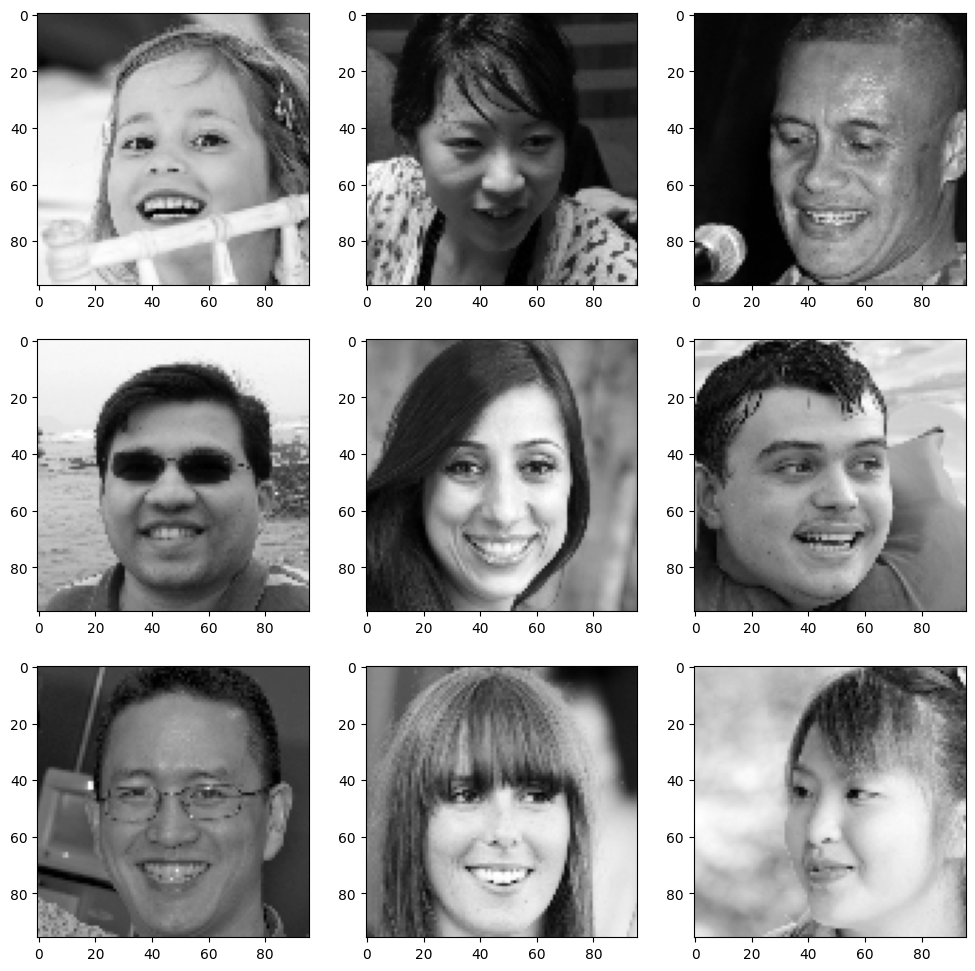

In [7]:
picture_size = 96
images = np.ndarray(shape=(28175, 96, 96, 3), dtype=int) #rgb

imagesg = np.ndarray(shape=(28175, 96, 96, 1), dtype=int) #gray
folder_path = "/content/affectnet-training-data/"
expression = 'happy'

plt.figure(figsize=(12, 12))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)
    img = load_img(folder_path + expression + "/" +
                   os.listdir(folder_path + expression)[i], target_size=(picture_size, picture_size))
    img = img.convert('L')  #to pillow convert it to gray scale
    imagesg[i] = img_to_array(img) 
    plt.imshow(img,cmap='gray')  #to matplotlip convert it to gray
plt.show()

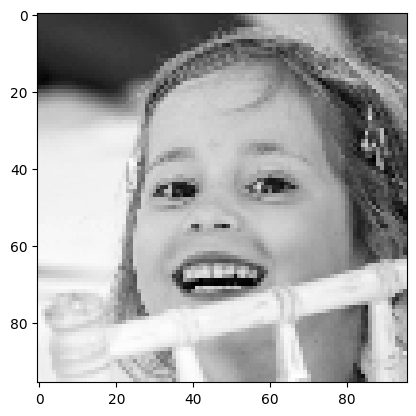

In [8]:
plt.imshow(imagesg[1],cmap="gray")


In [9]:

plt.figure(figsize=(12, 12))
for i in range(0, len(df)):
    # plt.subplot(3, 3, i)
    img = load_img(folder_path + df['pth'][i], target_size=(picture_size, picture_size))
    img = img.convert('L')  #to pillow convert it to gray scale
    imagesg[i] = img_to_array(img) 
    # plt.imshow(img,cmap='gray')  #to matplotlip convert it to gray
# plt.show()


<Figure size 1200x1200 with 0 Axes>

In [10]:
label=[]
labels=[]
for i in range(0,len(df['pth'])):
    label=df['pth'][i].split("/")[0]
    labels.append(label)
df2=pd.DataFrame(labels)

In [11]:
#df2.rename(columns={df2[:1]:'label'},inplace=True)
df2.columns=["label"]

In [12]:
df2

,label
0,anger
1,anger
2,anger
3,anger
4,anger
...,...
28170,surprise
28171,surprise
28172,surprise
28173,surprise


In [13]:
df = pd.merge(df["pth"],df2["label"], how ='right', left_index=True, right_index=True)

In [14]:
df

,pth,label
0,anger/image0000006.jpg,anger
1,anger/image0000060.jpg,anger
2,anger/image0000061.jpg,anger
3,anger/image0000066.jpg,anger
4,anger/image0000106.jpg,anger
...,...,...
28170,surprise/image0034960.jpg,surprise
28171,surprise/image0034961.jpg,surprise
28172,surprise/image0034966.jpg,surprise
28173,surprise/image0034973.jpg,surprise


In [15]:
df['label']=df['label'].astype('category')
df['label']=df['label'].cat.codes
df

,pth,label
0,anger/image0000006.jpg,0
1,anger/image0000060.jpg,0
2,anger/image0000061.jpg,0
3,anger/image0000066.jpg,0
4,anger/image0000106.jpg,0
...,...,...
28170,surprise/image0034960.jpg,7
28171,surprise/image0034961.jpg,7
28172,surprise/image0034966.jpg,7
28173,surprise/image0034973.jpg,7


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28175 entries, 0 to 28174
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pth     28175 non-null  object
 1   label   28175 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 247.8+ KB


In [17]:

x=imagesg
y=df['label']
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=1)

# New Section

In [46]:
from keras.optimizers import Adam,SGD,RMSprop
from keras.losses import SparseCategoricalCrossentropy

batch_size  = 32

no_of_classes = 8

model = Sequential()

#1st CNN layer
model.add(Conv2D(64, (3,3), padding="same", activation='selu', input_shape = (picture_size,picture_size,1), kernel_regularizer='l2'))
model.add(Conv2D(64, (3,3), padding="same", activation='selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
model.add(Dropout(0.40))

#2nd CNN layer
model.add(Conv2D(128, (3,3), padding="same", activation='selu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same", activation='selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
model.add(Dropout(0.40))

#3rd CNN layer
model.add(Conv2D(256, (3,3), padding="same", activation='selu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding="same", activation='selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
model.add(Dropout(0.40))

#4th CNN layer
model.add(Conv2D(512, (3,3), padding="same", activation='selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
model.add(Dropout(0.40))

# 5th CNN layer
model.add(Conv2D(1024, (3,3), padding="same", activation='selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.40))

model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.50))

#Fully connected 2nd layer
model.add(Dense(256, activation='selu'))
model.add(Dropout(0.50))

#Last Dense Layer
model.add(Dense(no_of_classes, activation='softmax'))

optimizer=Adam(lr=0.0001)
model.compile(optimizer =optimizer , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 batch_normalization_11 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 128)      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


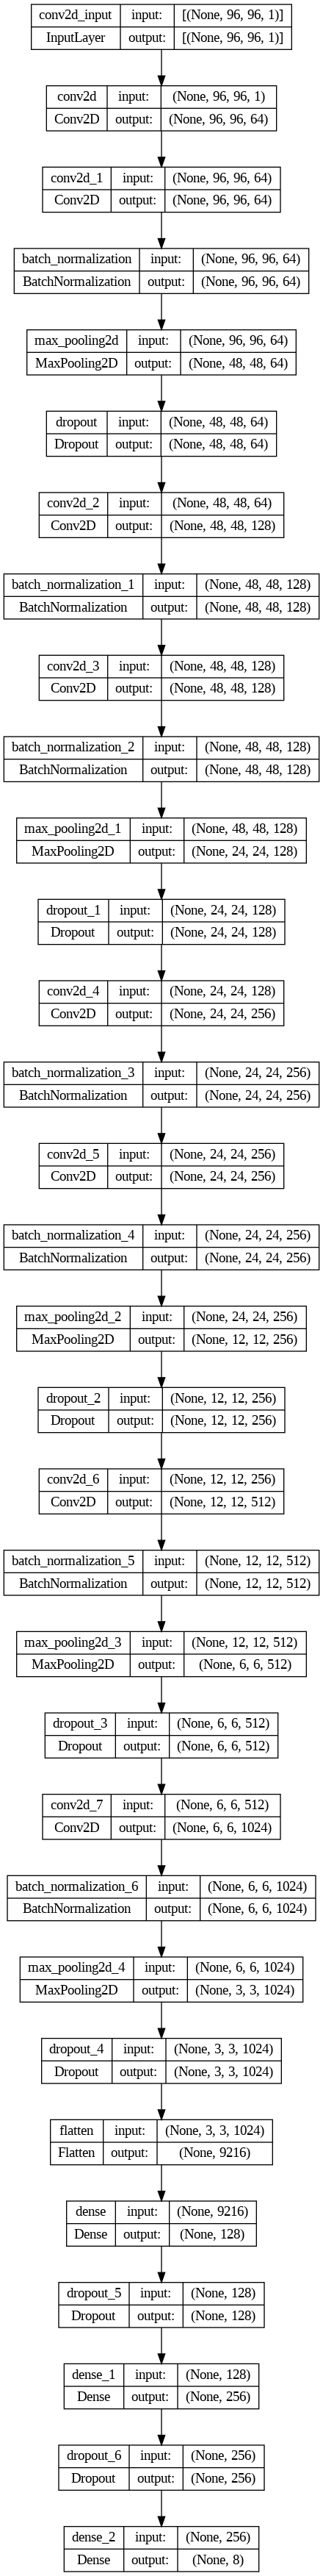

In [28]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, show_shapes=True,show_layer_names=True)

In [19]:
y_test.shape

(5635,)

In [29]:
model1=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=35,batch_size=batch_size)

Epoch 1/35
705/705 [==============================] - 87s 107ms/step - loss: 3.8218 - accuracy: 0.1632 - val_loss: 1.9492 - val_accuracy: 0.2999
Epoch 2/35
705/705 [==============================] - 75s 107ms/step - loss: 2.7382 - accuracy: 0.2506 - val_loss: 1.7423 - val_accuracy: 0.3723
Epoch 3/35
705/705 [==============================] - 75s 107ms/step - loss: 2.3584 - accuracy: 0.2924 - val_loss: 1.6531 - val_accuracy: 0.3831
Epoch 4/35
705/705 [==============================] - 75s 107ms/step - loss: 2.1035 - accuracy: 0.3409 - val_loss: 1.5068 - val_accuracy: 0.4387
Epoch 5/35
705/705 [==============================] - 75s 107ms/step - loss: 1.9258 - accuracy: 0.3710 - val_loss: 1.4005 - val_accuracy: 0.4878
Epoch 6/35
705/705 [==============================] - 75s 106ms/step - loss: 1.7901 - accuracy: 0.3957 - val_loss: 1.3528 - val_accuracy: 0.4873
Epoch 7/35
705/705 [==============================] - 76s 108ms/step - loss: 1.6792 - accuracy: 0.4142 - val_loss: 1.2839 - val_ac

In [30]:
model.evaluate(x_test,y_test)

177/177 [==============================] - 5s 27ms/step - loss: 0.9241 - accuracy: 0.6889


[0.9241300821304321, 0.6889086365699768]

In [31]:
model.save('model.h5')
model.load('model.h5')

In [31]:
import cv2
import numpy as np

img = cv2.imread("/content/affectnet-training-data/fear/image0000285.jpg",0)
img = cv2.resize(img, (96, 96))
img = np.reshape(img, [1, 96, 96, 1])
print(np.argmax(model.predict(img)))

1/1 [==============================] - 1s 581ms/step
3


In [32]:
y_pred = np.argmax(model.predict(x_test))
y_true = np.argmax(y_test)
print("y predict is: ",y_pred," y true is: ",y_true)

177/177 [==============================] - 4s 23ms/step
y predict is:  1380  y true is:  0


In [33]:
def emotion(em):
  if(em == 0):
    print("anger")
  elif(em==1):
    print("contempt")
  elif(em==2):
    print("disgust")
  elif(em==3):
    print("fear")
  elif(em==4):
    print("happy")
  elif(em==5):
    print("neutral")
  elif (em==6):
    print("sad")
  elif (em==7):
    print("surprise")
  return em

In [41]:
import cv2
img = cv2.imread("/content/affectnet-training-data/surprise/ffhq_108.png",0)
img = cv2.resize(img, (96, 96))
img = np.reshape(img, [1, 96, 96, 1])
print("The emotion is: ")
pred=emotion(np.argmax(model.predict(img)))

The emotion is: 
1/1 [==============================] - 0s 20ms/step
surprise


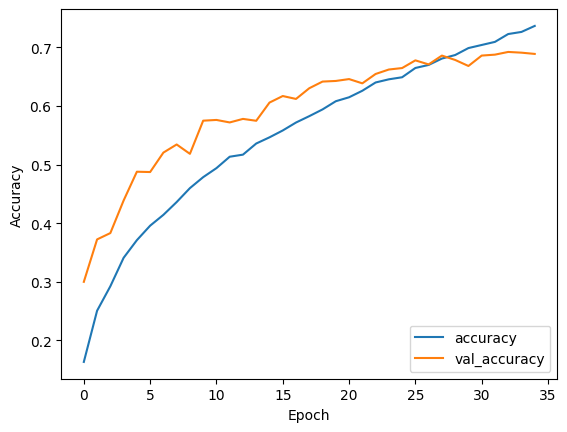

In [42]:
plt.plot(model1.history['accuracy'],label='accuracy')
plt.plot(model1.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

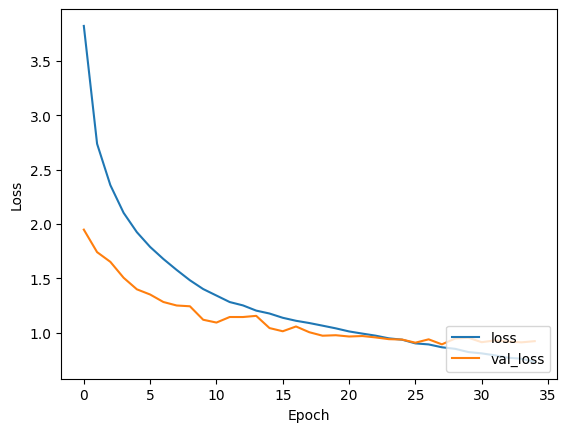

In [43]:
plt.plot(model1.history['loss'],label='loss')
plt.plot(model1.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [18]:
from keras.optimizers import Adam,SGD,RMSprop

model_2 = Sequential()

model_2.add(Conv2D(32, (3,3), activation="relu", input_shape = (picture_size,picture_size,1)))
model_2.add(Conv2D(32, (3,3), activation="relu", input_shape = (picture_size,picture_size,1)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size = (2,2), strides = 2))
model_2.add(Dropout(0.50))

model_2.add(Conv2D(64, (3,3), activation="relu"))
model_2.add(Conv2D(64, (3,3), activation="relu"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size = (2,2), strides = 2))
model_2.add(Dropout(0.50))

model_2.add(Conv2D(128, (3,3), activation="relu"))
model_2.add(Conv2D(128, (3,3), activation="relu"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size = (2,2), strides = 2))
model_2.add(Dropout(0.50))

model_2.add(Flatten())
model_2.add(Dense(256, activation='relu', kernel_regularizer="l2"))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.50))
model_2.add(Dense(8, activation='softmax'))

model_2.compile(optimizer = Adam(learning_rate=0.001), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

model_2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 64)        1

In [20]:
model2=model_2.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=32)

Epoch 1/10
705/705 [==============================] - 37s 38ms/step - loss: 4.2678 - accuracy: 0.3937 - val_loss: 2.3203 - val_accuracy: 0.4914
Epoch 2/10
705/705 [==============================] - 23s 33ms/step - loss: 2.0949 - accuracy: 0.5118 - val_loss: 1.9929 - val_accuracy: 0.4978
Epoch 3/10
705/705 [==============================] - 24s 33ms/step - loss: 2.0347 - accuracy: 0.5280 - val_loss: 2.1715 - val_accuracy: 0.4854
Epoch 4/10
705/705 [==============================] - 24s 34ms/step - loss: 2.0024 - accuracy: 0.5489 - val_loss: 2.0183 - val_accuracy: 0.5579
Epoch 5/10
705/705 [==============================] - 24s 34ms/step - loss: 1.9801 - accuracy: 0.5598 - val_loss: 2.0898 - val_accuracy: 0.4763
Epoch 6/10
705/705 [==============================] - 24s 34ms/step - loss: 1.9085 - accuracy: 0.5695 - val_loss: 1.8374 - val_accuracy: 0.6041
Epoch 7/10
705/705 [==============================] - 24s 34ms/step - loss: 1.9184 - accuracy: 0.5739 - val_loss: 1.8913 - val_accuracy:

In [21]:
model_2.evaluate(x_test,y_test)

177/177 [==============================] - 1s 8ms/step - loss: 1.7635 - accuracy: 0.6298


[1.7635420560836792, 0.6298136711120605]

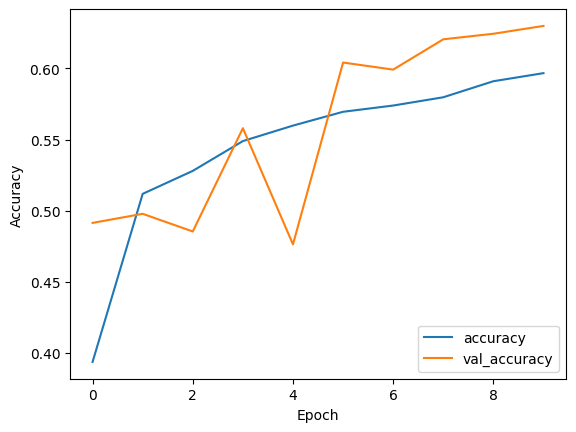

In [24]:
plt.plot(model2.history['accuracy'],label='accuracy')
plt.plot(model2.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

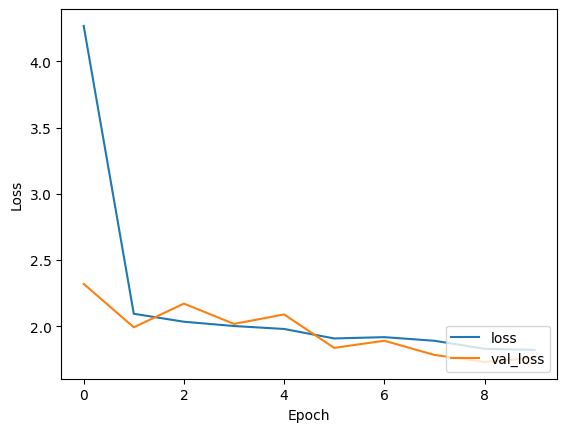

In [26]:
plt.plot(model2.history['loss'],label='loss')
plt.plot(model2.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()